In [1]:
import glob
import pandas as pd
import dask.dataframe as dd

### I. Forming the Dataframe

In [2]:
# getting all cases after 2015 and concatenating them into one dataframe

cases = pd.concat([pd.read_csv(f) for f in glob.glob('./csv/cases/*.csv') if int(f[18:22]) > 2015], ignore_index = True)
cases.head()

,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,01-01-01-201900000012016,2016,1,1,1,MHNB030000032016,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,767.0,26,2016-01-02,2016-02-16,2016-01-02,2016-02-16,2016-02-16
1,01-01-01-201900000022016,2016,1,1,1,MHNB030000042016,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,767.0,26,2016-01-02,2016-02-16,2016-01-02,2016-02-16,2016-02-16
2,01-01-01-201900000032016,2016,1,1,1,MHNB030000052016,chief judicial magistrate,0 male,1 female,-9999,0,1940.0,4878.0,43,2016-01-02,2016-02-13,2016-01-02,2016-02-13,2016-02-13
3,01-01-01-201900000042016,2016,1,1,1,MHNB030000062016,chief judicial magistrate,0 male,0 male,-9999,1,1940.0,7430.0,23,2016-01-05,2017-06-07,2016-01-05,2017-06-07,2017-06-07
4,01-01-01-201900000052016,2016,1,1,1,MHNB030000072016,chief judicial magistrate,0 male,0 male,-9999,0,1940.0,5251.0,26,2016-01-06,2016-02-18,2016-01-06,2016-02-18,2016-02-18


### II. Data Cleaning & Preprocessing

In [3]:
cases_pre = cases.copy()

# removing columns that are not needed for the analysis
cases_pre = cases_pre.drop(['date_first_list', 'date_last_list', 'date_next_list', 'cino', 'date_of_filing', 'date_of_decision', 'ddl_case_id'], axis=1)
cases_pre = cases_pre.drop_duplicates()

print(cases_pre.shape)

(7701751, 12)


In [4]:
# removing strings from the columns and making them integers

cases_pre['female_defendant'] = cases_pre['female_defendant'].str.replace('[a-zA-Z]', '', regex=True).astype('int')
cases_pre['female_petitioner'] = cases_pre['female_petitioner'].str.replace('[a-zA-Z]', '', regex=True).astype('int')

In [5]:
# remove cases where the genders are not mentioned or unclear 

cases_pre = cases_pre.loc[(cases_pre['female_adv_def'] != -9999) & (cases_pre['female_adv_def'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_adv_pet'] != -9999) & (cases_pre['female_adv_pet'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_defendant'] != -9999) & (cases_pre['female_defendant'] != -9998)]
cases_pre = cases_pre.loc[(cases_pre['female_petitioner'] != -9999) & (cases_pre['female_petitioner'] != -9998)]

In [6]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,2016,1,1,1,chief judicial magistrate,0,1,1,0,1940.0,2813.0,16
11,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,5426.0,23
12,2016,1,1,1,chief judicial magistrate,0,1,0,1,1940.0,2813.0,27
18,2016,1,1,1,chief judicial magistrate,0,1,0,0,1940.0,767.0,33
37,2016,1,1,1,chief judicial magistrate,0,0,0,0,1940.0,2813.0,46


#### Saving up on memory by downcasting the data types of the columns

In [7]:
# fill missing values with mode and drop all non-finite values

import numpy as np

# cases_pre = cases_pre.fillna(cases_pre.mode())
cases_pre = cases_pre.replace([np.inf, -np.inf], np.nan)
cases_pre = cases_pre.dropna()

In [8]:
cases_pre.dtypes

year                   int64
state_code             int64
dist_code              int64
court_no               int64
judge_position        object
female_defendant       int64
female_petitioner      int64
female_adv_def         int64
female_adv_pet         int64
type_name            float64
purpose_name         float64
disp_name              int64
dtype: object

In [9]:
cases_pre.memory_usage(deep=True)

Index                 2786848
year                  2786848
state_code            2786848
dist_code             2786848
court_no              2786848
judge_position       27710368
female_defendant      2786848
female_petitioner     2786848
female_adv_def        2786848
female_adv_pet        2786848
type_name             2786848
purpose_name          2786848
disp_name             2786848
dtype: int64

In [10]:
# downcasting the data types

cases_pre['judge_position'] = cases_pre['judge_position'].astype('category')
cases_pre['purpose_name'] = cases_pre['purpose_name'].astype('uint8')
cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name']] = cases_pre[['year', 'state_code', 'dist_code', 'court_no', 'disp_name', 'female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet', 'type_name', 'purpose_name']].apply(pd.to_numeric, downcast='unsigned')

In [11]:
cases_pre.dtypes

year                   uint16
state_code              uint8
dist_code               uint8
court_no                uint8
judge_position       category
female_defendant        uint8
female_petitioner       uint8
female_adv_def          uint8
female_adv_pet          uint8
type_name              uint16
purpose_name            uint8
disp_name               uint8
dtype: object

In [12]:
# ordinal encoding of judge_position
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
cases_pre['judge_position'] = encoder.fit_transform(cases_pre[['judge_position']])
cases_pre['judge_position'] = cases_pre['judge_position'].astype('uint8')

In [13]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,2016,1,1,1,102,0,1,1,0,1940,253,16
11,2016,1,1,1,102,0,1,0,0,1940,50,23
12,2016,1,1,1,102,0,1,0,1,1940,253,27
18,2016,1,1,1,102,0,1,0,0,1940,255,33
37,2016,1,1,1,102,0,0,0,0,1940,253,46


#### Compare the correlation of attributes to select the best ones for the model

<AxesSubplot: >

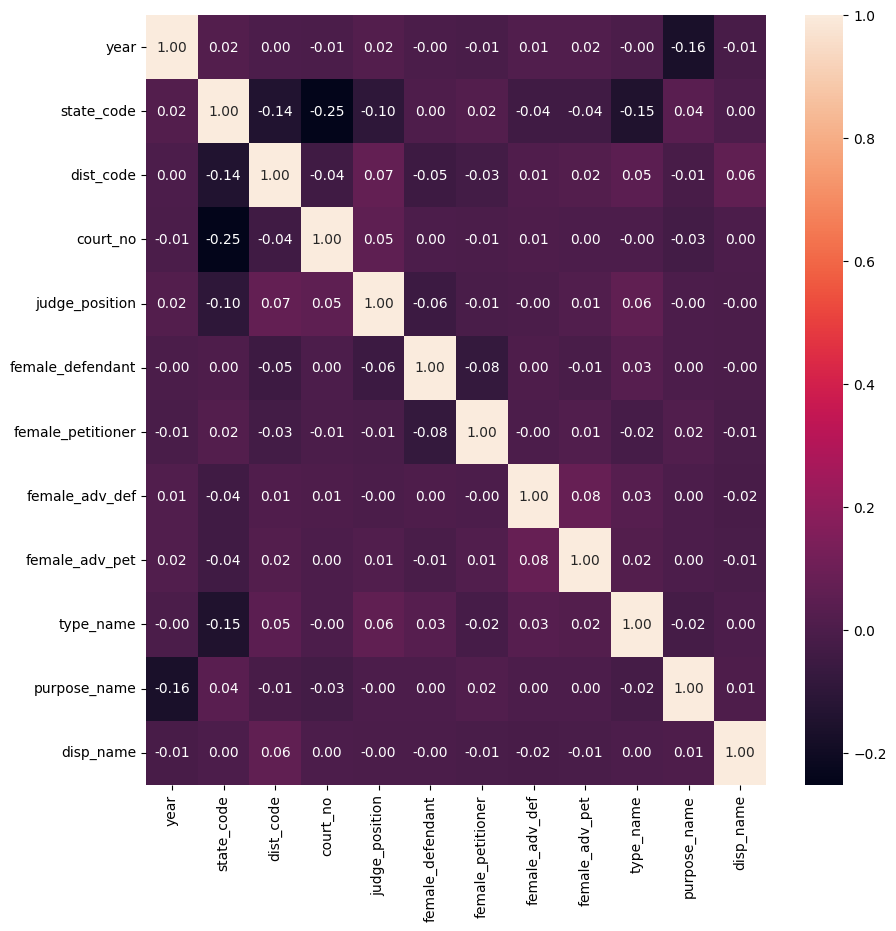

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
 
# correlation matrix
corr = cases_pre.corr(numeric_only=True)
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f')

In [15]:
cases_pre.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name
5,2016,1,1,1,102,0,1,1,0,1940,253,16
11,2016,1,1,1,102,0,1,0,0,1940,50,23
12,2016,1,1,1,102,0,1,0,1,1940,253,27
18,2016,1,1,1,102,0,1,0,0,1940,255,33
37,2016,1,1,1,102,0,0,0,0,1940,253,46


#### Check which attribute is best to classify on

In [16]:
print(cases_pre['type_name'].nunique())
print(cases_pre['purpose_name'].nunique())
print(cases_pre['disp_name'].nunique())

print(cases_pre.shape)

4577
256
50
(348356, 12)


In [80]:
# merge with type_name_key csv to get the type_name in english and group similar type names together

type_name_key = pd.read_csv('./csv/keys/type_name_key.csv')
merged = pd.merge(cases_pre, type_name_key, on=['type_name', 'year'], how='left')
merged = merged.drop(['type_name', 'count'], axis=1)

# print(merged.shape)

# disp_name_key = pd.read_csv('./csv/keys/disp_name_key.csv')
# merged = pd.merge(merged, disp_name_key, on=['disp_name', 'year'], how='left')
# merged = merged.drop(['disp_name', 'count'], axis=1)
# # print(merged['type_name'].nunique())

In [76]:
merged.head()

,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,purpose_name,disp_name,type_name_s
0,2016,1,1,1,102,0,1,1,0,253,16,cri.m.a.
1,2016,1,1,1,102,0,1,0,0,50,23,cri.m.a.
2,2016,1,1,1,102,0,1,0,1,253,27,cri.m.a.
3,2016,1,1,1,102,0,1,0,0,255,33,cri.m.a.
4,2016,1,1,1,102,0,0,0,0,253,46,cri.m.a.


In [81]:
# remove everything after the first word in type_name_s

merged['type_name_s'] = merged['type_name_s'].str.split(' ').str[0]

# ordinal encoding of type_name_s

# merged['type_name_s'] = encoder.fit_transform(merged[['type_name_s']])
# merged['type_name_s'] = merged['type_name_s'].astype('uint8')

merged.head()


,year,state_code,dist_code,court_no,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,purpose_name,disp_name,type_name_s
0,2016,1,1,1,102,0,1,1,0,253,16,cri.m.a.
1,2016,1,1,1,102,0,1,0,0,50,23,cri.m.a.
2,2016,1,1,1,102,0,1,0,1,253,27,cri.m.a.
3,2016,1,1,1,102,0,1,0,0,255,33,cri.m.a.
4,2016,1,1,1,102,0,0,0,0,253,46,cri.m.a.


In [82]:
# taking disp_name as the target attribute, check what is good predictor for disp_name

# do chi square test and get 10 best predictors

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = merged.drop(['type_name_s'], axis=1)
y = merged['type_name_s']

bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

featureScores.nlargest(10,'Score')

,Specs,Score
1,state_code,1.510872e+06
4,judge_position,1.498838e+06
2,dist_code,8.588962e+05
3,court_no,7.642445e+05
9,purpose_name,3.439390e+05
10,disp_name,1.067493e+05
6,female_petitioner,2.164970e+04
5,female_defendant,2.115419e+04
7,female_adv_def,8.967878e+03
8,female_adv_pet,7.961482e+03


In [83]:
# drop the columns that are not needed for the analysis

merged = merged.drop(['female_defendant', 'female_petitioner', 'female_adv_def', 'female_adv_pet'], axis=1)

In [84]:
merged.head()
# merged = merged.drop(['year', 'state_code', 'dist_code', 'court_no', 'judge_position', 'purpose_name', 'female_petitioner', 'female_adv_def', 'female_adv_pet'], axis=1)

,year,state_code,dist_code,court_no,judge_position,purpose_name,disp_name,type_name_s
0,2016,1,1,1,102,253,16,cri.m.a.
1,2016,1,1,1,102,50,23,cri.m.a.
2,2016,1,1,1,102,253,27,cri.m.a.
3,2016,1,1,1,102,255,33,cri.m.a.
4,2016,1,1,1,102,253,46,cri.m.a.


In [85]:
merged_nodup = merged.drop_duplicates()

In [24]:
merged_nodup.shape

(237818, 8)

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = merged_nodup.drop(['type_name_s'], axis=1)
y = merged_nodup['type_name_s']

X_train, X_test, y_train, y_test = train_test_split(X, y)


In [ ]:
# logistic regression with disp_name as target on large dataset

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.49
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00       225
           3       0.00      0.00      0.00        23
           4       0.00      0.00      0.00      1585
           5       0.00      0.00      0.00      7561
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00       542
           8       0.00      0.00      0.00        22
          10       0.00      0.00      0.00        10
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00       324
          14       0.00      0.00      0.00       110
          15       0.00      0.00      0.00        45
        

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVMs are not suitable for large datasets
The original SVM implementation is known to have a concrete theoretical foundation, but it is not suitable for classifying in large datasets for one straightforward reason — the complexity of the algorithm's training is highly dependent on the size of the dataset.

In [ ]:
# knn with disp_name as target on large dataset

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print('Accuracy of KNN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of KNN classifier on test set: 0.49
[[  0   0   0 ...   0   0   0]
 [  0   3   0 ...   0   0   9]
 [  0   0   1 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  1  10   0 ...   0   0 472]]


/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

               258 crpc       0.00      0.00      0.00        12
                 abated       0.02      0.01      0.02       225
              absconded       0.05      0.04      0.05        23
              acquitted       0.28      0.35      0.31      1585
                allowed       0.28      0.38      0.33      7561
        appeal accepted       0.14      0.08      0.10        26
                  award       0.23      0.21      0.22       542
           bail granted       0.17      0.09      0.12        22
           bail refused       0.00      0.00      0.00        10
          bail rejected       0.14      0.17      0.15         6
              cancelled       0.00      0.00      0.00         1
                 closed       0.19      0.15      0.17       324
              committed       0.06      0.04      0.04       110
             compounded       0.07      0.07      0.07        45
             compromise 

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# decision tree with disp_name as target on large dataset

from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('Accuracy of decision tree classifier on test set: {:.2f}'.format(dtree.score(X_test, y_test)))

# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of decision tree classifier on test set: 0.62
[[   2    0    0 ...    0    0    0]
 [   0   36    0 ...    0    0   13]
 [   0    0    2 ...    0    0    2]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    4    0]
 [   0   10    0 ...    0    0 1997]]
              precision    recall  f1-score   support

           0       0.13      0.15      0.14        13
           1       0.15      0.14      0.15       249
           2       0.09      0.07      0.08        29
           3       0.50      0.53      0.52      2621
           4       0.56      0.67      0.61     17718
           5       0.03      0.04      0.03        27
           6       0.50      0.51      0.50      1174
           7       0.51      0.72      0.60        43
           8       0.50      0.50      0.50        10
           9       0.46      0.35      0.40        17
          10       0.00      0.00      0.00         3
          11       0.27      0.30      0.29       381
          12  

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [89]:
# random forest on disp_name as target on large dataset

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

: 

: 

In [ ]:

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


0.4890230963845589
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

               258 crpc       0.00      0.00      0.00         7
                 abated       0.00      0.00      0.00       160
              absconded       0.00      0.00      0.00        15
              acquitted       0.00      0.00      0.00      1309
                allowed       0.00      0.00      0.00      6216
        appeal accepted       0.00      0.00      0.00        16
                  award       0.00      0.00      0.00       475
           bail granted       0.00      0.00      0.00        23
           bail refused       0.00      0.00      0.00         6
          bail rejected       0.00      0.00      0.00         5
              cancelled       0.00      0.00      0.00         3
                 closed       0.00      0.00      0.00       281
              committed       0.00      0.00      0.00       106
             compounded       0.00      0.00      0.00        32
             compromise 

/home/swetha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
